## Dataset loading



In [1]:
#! pip install gensim

In [2]:
import pandas as pd
import numpy as np
import pandas as pd
import tensorflow as tf
import string
import re
import random
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import word2vec, FastText
import gensim.downloader
from sklearn.decomposition import PCA

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip /content/drive/MyDrive/ner.csv.zip
!unzip /content/drive/MyDrive/ner_dataset.csv.zip

Archive:  /content/drive/MyDrive/ner.csv.zip
  inflating: ner.csv                 
Archive:  /content/drive/MyDrive/ner_dataset.csv.zip
  inflating: ner_dataset.csv         


In [5]:
df=pd.read_csv('/content/ner_dataset.csv', encoding= 'unicode_escape')

In [6]:
df['Sentence #']=df['Sentence #'].ffill()

In [7]:
%pip install datasets transformers
%pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.6 MB/s eta 0:00:00


In [8]:
# import pandas as pd
# column_names = ['Token', 'POS']
# df_train = pd.read_csv("wnut 16.txt.conll", sep='\t', header=None,names=column_names ,comment='#')
# df_test = pd.read_csv("wnut 16test.txt.conll", sep='\t', header=None,names=column_names ,comment='#')
# df_train.head()

In [9]:
df=df[['Sentence #','Word','Tag']]
df.rename(columns={'Sentence #':'Sentence','Word':'Token','Tag':'POS'},inplace=True)

<ipython-input-9-e444fee1884a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Sentence #':'Sentence','Word':'Token','Tag':'POS'},inplace=True)


In [10]:
df

,Sentence,Token,POS
0,Sentence: 1,Thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O
4,Sentence: 1,marched,O
...,...,...,...
1048570,Sentence: 47959,they,O
1048571,Sentence: 47959,responded,O
1048572,Sentence: 47959,to,O
1048573,Sentence: 47959,the,O


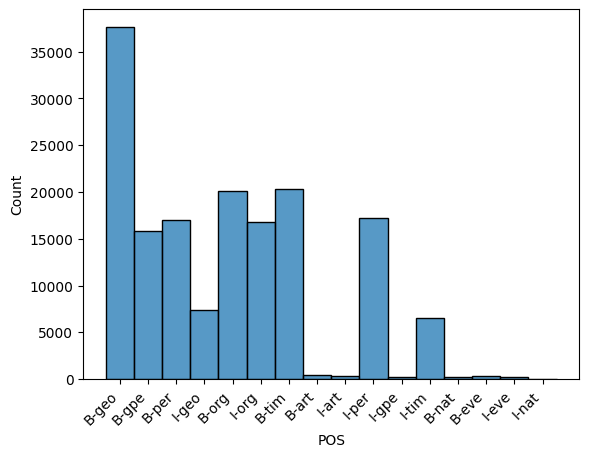

In [11]:
sns.histplot(df[df['POS']!='O']['POS'])
plt.xticks(rotation=45, ha='right')
plt.show()

Clearly there is imbalance in the dataset. Person, Other and loc has the highest count compare to other tags. We will take care of that in loss

In [12]:
df.info() #There seems to be no null

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   Sentence  1048575 non-null  object
 1   Token     1048575 non-null  object
 2   POS       1048575 non-null  object
dtypes: object(3)
memory usage: 24.0+ MB


In [13]:
print('Number of sentences are '+str(df['Sentence'].nunique()))
print('Number of Vocabs are '+str(df['Token'].nunique()))

Number of sentences are 47959
Number of Vocabs are 35178


# BLSTM-CRF

## Model Building LSTM and CRF


## Data Preprocessing

In [14]:
import xml.etree.ElementTree as ET
import tensorflow as tf
from keras.layers import TextVectorization
import gensim.downloader as api
from keras.layers import Embedding

tf.random.set_seed(123)

In [15]:
df['Token']=df['Token'].str.lower()

In [16]:
sentence_all = [(list(zip(group['Token'], group['POS']))) for _, group in df.groupby('Sentence')]

In [17]:
sentence_all[0] #1st Sentence

[('thousands', 'O'),
 ('of', 'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('london', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('british', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]

In [18]:
# sentences = []
# for sample in sentence_all:
#   sentence = [i[0] for i in sample]
#   sentences.append(sentence)

# tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=df['Token'].nunique(), lower=True)
# tokenizer.fit_on_texts(sentences)

In [19]:
#tokenizer.shape

In [20]:
#tokenizer.word_index.items()

In [21]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    BATCH_SIZE = 512  # Number of examples used in each iteration
    EPOCHS = 5  # Number of passes through entire dataset
    MAX_LEN = 75  # Max length of review (in words)
    EMBEDDING = 40  # Dimension of word embedding vector
# Hyperparams for CPU training
else:
    BATCH_SIZE = 32
    EPOCHS = 5
    MAX_LEN = 75
    EMBEDDING = 20

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [22]:
#BATCH_SIZE

In [23]:
! pip install keras_preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 443.0 kB/s eta 0:00:00


In [24]:
words = list(set(df['Token'].values))
tags = list(set(df["POS"].values))

In [25]:
'thousands'in words

True

In [26]:
#Creating word to index and tag to index
import sklearn

# Vocabulary Key:word -> Value:token_index
# The first 2 entries are reserved for PAD and UNK
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding

# Vocabulary Key:token_index -> Value:word
idx2word = {i: w for w, i in word2idx.items()}

# Vocabulary Key:Label/Tag -> Value:tag_index
# The first entry is reserved for PAD
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0

# Vocabulary Key:tag_index -> Value:Label/Tag
idx2tag = {i: w for w, i in tag2idx.items()}


In [27]:
#'thousands' in list(word2idx.keys())

In [28]:
# Embedding the word matrix, we will add this
hits = 0
misses = 0
word2vec = api.load("word2vec-google-news-300")
embedding_dim = 300

# Prepare embedding matrix
embedding_matrix = np.zeros((len(word2idx), embedding_dim))
for word, i in zip(word2idx.keys(),word2idx.values()):
    embedding_vector = None
    try:
      embedding_vector = word2vec[word]
    except Exception :
      pass

    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

[==================================================] 100.0% 1662.8/1662.8MB downloaded
Converted 19600 words (12219 misses)


In [29]:
#! pip install keras_preprocessing

In [30]:
#Tagging word to index and tag to index

#from keras.preprocessing.sequence import pad_sequences
#from keras_preprocessing.sequence import pad_sequences
from keras_preprocessing.sequence import pad_sequences

# Convert each sentence from list of Token to list of word_index
X = [[word2idx[w[0]] for w in s] for s in sentence_all]

# Padding each sentence to have the same lenght
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])

# Convert Tag/Label to tag_index
y = [[tag2idx[w[1]] for w in s] for s in sentence_all]

# Padding each sentence to have the same lenght
y = pad_sequences(maxlen=75, sequences=y, padding="post", value=tag2idx["PAD"])
from keras.utils import to_categorical

# One-Hot encode
y = [to_categorical(i, num_classes=len(tags)+1) for i in y]  # n_tags+1(PAD)
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)
X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape


print('Raw Sample:\n ', ' '.join([w[0] for w in sentence_all[1]]))
print('\n ' )
print('Raw Label:\n ', ' '.join([w[1] for w in sentence_all[1]]))
print('\n ' )
print('After processing, sample:\n', X[0])
print('\n ' )
print('After processing, labels:\n', y[0])

Raw Sample:
  iranian officials say they expect to get access to sealed sensitive parts of the plant wednesday , after an iaea surveillance system begins functioning .

 
Raw Label:
  B-gpe O O O O O O O O O O O O O O B-tim O O O B-org O O O O O

 
After processing, sample:
 [16284 15545  9966 27814 12276 11485  6025   108  5384 11509 20771 14315
  5088 28800  9002 11509  9740 15545 26488 20825 26421  1585  6315 18090
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]

 
After processing, labels:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [31]:
#sentence_all

In [32]:
len(word2idx)

31819

In [33]:
X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape

((43163, 75), (4796, 75), (43163, 75, 18), (4796, 75, 18))

In [34]:
y_tr = np.array(y_tr)
y_te = np.array(y_te)

In [35]:
#! pip install tensorflow_addons

In [36]:
# !pip install tensorflow-addons
# !pip install tensorflow==2.0.0-beta1

## Model Building

In [37]:
#len(word2idx)

In [66]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow_addons.utils.types import FloatTensorLike, TensorLike
from tensorflow_addons.layers import CRF
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from tensorflow_addons.optimizers import AdamW



def build_model(max_len = 75, input_dim = len(word2idx),embedding_dim = 300):
  # Model definition
  input = Input(shape=(max_len,))

  # Get embeddings
  embeddings = Embedding(
      input_dim,
      embedding_dim,
      weights=[embedding_matrix],
    input_length=max_len,
       mask_zero=True,
    trainable=True,
      name = 'embedding_layer'
  )(input)

  # variational biLSTM
  output_sequences = Bidirectional(LSTM(units=50, return_sequences=True))(embeddings)
  output_sequences = Bidirectional(LSTM(units=100, return_sequences=True))(output_sequences)
  # Stacking
  output_sequences = Bidirectional(LSTM(units=50, return_sequences=True))(output_sequences)

  # Adding more non-linearity
  dense_out = TimeDistributed(Dense(25, activation="relu"))(output_sequences)

  # CRF layer
  mask = Input(shape=(max_len,), dtype=tf.bool)
  crf = CRF(18, name='crf')
  predicted_sequence, potentials, sequence_length, crf_kernel = crf(dense_out)

  model = Model(input, potentials)
  model.compile(
      optimizer=AdamW(weight_decay=0.001),
      loss= SigmoidFocalCrossEntropy()) # Sigmoid focal cross entropy loss

  return model

model = build_model()

# Checkpointing
save_model = tf.keras.callbacks.ModelCheckpoint(filepath='ner_crf.h5',
  monitor='val_loss',
  save_weights_only=True,
  save_best_only=True,
  verbose=1
)

# Early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=10)

callbacks = [save_model, es]

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 75)]              0         
                                                                 
 embedding_layer (Embedding  (None, 75, 300)           9545700   
 )                                                               
                                                                 
 bidirectional_3 (Bidirecti  (None, 75, 100)           140400    
 onal)                                                           
                                                                 
 bidirectional_4 (Bidirecti  (None, 75, 200)           160800    
 onal)                                                           
                                                                 
 bidirectional_5 (Bidirecti  (None, 75, 100)           100400    
 onal)                                                     

## Evaluation

In [39]:
history = model.fit(
  X_tr,
  y_tr,
  batch_size=64,
  epochs=20,
  validation_data=(X_te, y_te),
  callbacks=callbacks,
  shuffle=True
)

Epoch 1/20


675/675 [==============================] - ETA: 0s - loss: 0.1581
Epoch 1: val_loss improved from inf to 0.03543, saving model to ner_crf.h5
675/675 [==============================] - 113s 91ms/step - loss: 0.1581 - val_loss: 0.0354
Epoch 2/20
675/675 [==============================] - ETA: 0s - loss: 0.0259
Epoch 2: val_loss improved from 0.03543 to 0.02059, saving model to ner_crf.h5
675/675 [==============================] - 48s 71ms/step - loss: 0.0259 - val_loss: 0.0206
Epoch 3/20
675/675 [==============================] - ETA: 0s - loss: 0.0166
Epoch 3: val_loss improved from 0.02059 to 0.01684, saving model to ner_crf.h5
675/675 [==============================] - 60s 89ms/step - loss: 0.0166 - val_loss: 0.0168
Epoch 4/20
675/675 [==============================] - ETA: 0s - loss: 0.0128
Epoch 4: val_loss improved from 0.01684 to 0.01525, saving model to ner_crf.h5
675/675 [==============================] - 35s 52ms/step - loss: 0.0128 - val_loss: 0.0153
Epoch 5/20
675/675 [======

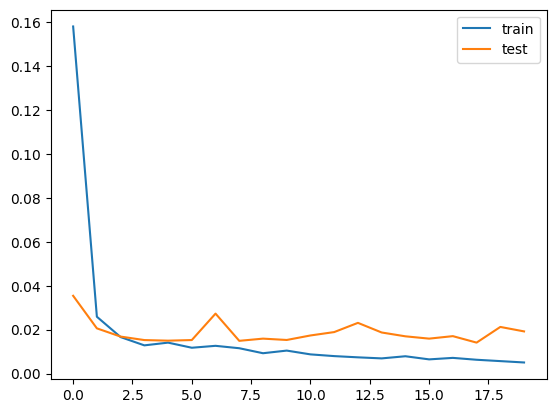

In [40]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Since it's still reducing there is a chance it will reduce more with more hyperparam tuning but loss of 0.02 for train and 0.14 with test looks great

150/150 [==============================] - 2s 11ms/step


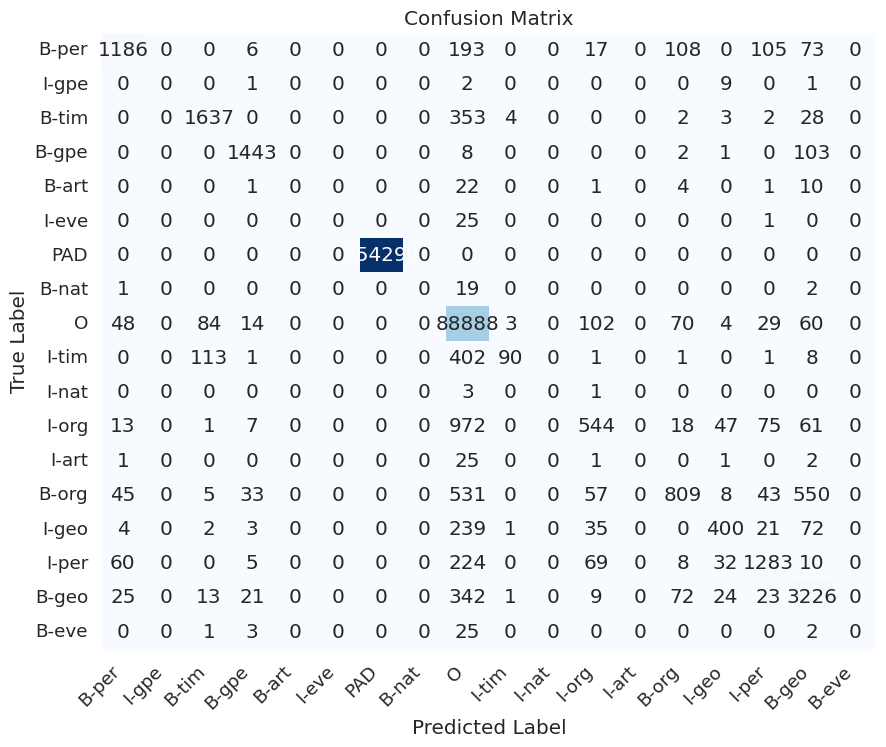

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Make predictions on the test set
predictions = model.predict(X_te)

# Convert predictions to POS tags
predicted_tags = np.argmax(predictions, axis=-1)
predicted_tags = [[idx2tag[tag] for tag in sample] for sample in predicted_tags]

# Flatten the predicted and true POS tag sequences
flatten_predicted = [tag for sample in predicted_tags for tag in sample]
flatten_true = [idx2tag[np.argmax(tag)] for sample in y_te for tag in sample]

# Get unique tags from the true and predicted sequences
unique_tags = list(set(flatten_true + flatten_predicted))

# Compute the confusion matrix
cm = confusion_matrix(flatten_true, flatten_predicted, labels=unique_tags)

# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=unique_tags, columns=unique_tags)

# Set up the plot
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="d", cbar=False)

# Customize the plot
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

# Show the plot
plt.show()


In [84]:
from sklearn.metrics import classification_report
print("Classification Report:\n ", classification_report(flatten_predicted, flatten_true, labels=unique_tags))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
                precision    recall  f1-score   support

       B-per       0.70      0.86      0.77      1383
       I-gpe       0.00      0.00      0.00         0
       B-tim       0.81      0.88      0.84      1856
       B-gpe       0.93      0.94      0.93      1538
       B-art       0.00      0.00      0.00         0
       I-eve       0.00      0.00      0.00         0
         PAD       1.00      1.00      1.00    254299
       B-nat       0.00      0.00      0.00         0
           O       1.00      0.96      0.98     92273
       I-tim       0.15      0.91      0.25        99
       I-nat       0.00      0.00      0.00         0
       I-org       0.31      0.65      0.42       837
       I-art       0.00      0.00      0.00         0
       B-org       0.39      0.74      0.51      1094
       I-geo       0.51      0.76      0.61       529
       I-per       0.76      0.81      0.78      1584
       B-geo       0.86      0.77      0.81      4208
  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


I can see that due to imbalance there are some category with less f1 score. We have used SigmoidFocalCrossEntropy to handle imbalance. We could further use either re-sampling method or more training methods

## Conclusion

In [69]:
model.load_weights('/content/ner_crf.h5')

In [95]:
import numpy as np

def get_pos_tags(sentence):
    # Tokenize the sentence
    tokens = sentence.lower().split()

    # Convert tokens to word indices
    word_indices = [word2idx.get(token, word2idx["UNK"]) for token in tokens]

    # Pad the sequence
    padded_sequence = pad_sequences([word_indices], maxlen=MAX_LEN, padding="post", value=word2idx["PAD"])

    # Make predictions
    predictions = model.predict(padded_sequence)[0]

    # Convert predictions to POS tags
    pos_tags = [idx2tag[np.argmax(pred)] for pred in predictions]

    return list(zip(tokens, pos_tags))

# Example usage
input_sentence = "Mike and Jake wanted to go to Disneyland"
output = get_pos_tags(input_sentence)

# Print the output
for token, pos_tag in output:
    print(f"Token: {token:<10} Predicted POS: {pos_tag}")


1/1 [==============================] - 0s 27ms/step
Token: mike       Predicted POS: B-per
Token: and        Predicted POS: I-per
Token: jake       Predicted POS: I-per
Token: wanted     Predicted POS: O
Token: to         Predicted POS: O
Token: go         Predicted POS: O
Token: to         Predicted POS: O
Token: disneyland Predicted POS: B-geo


This is the prediction of the sentence